In [63]:
# --- Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paths
base = "C:/Users/Justin/Documents/jdulyanu-tire-deg"
joined_path = f"{base}/data/processed/joined_laps_weather.csv"
circuits_path = f"{base}/data/metadata/circuit_features.csv"

# --- Load datasets
df_laps = pd.read_csv(joined_path)
df_circuits = pd.read_csv(circuits_path)

# --- Fix redundant circuit_id columns from the laps-weather join
if "circuit_id_y" in df_laps.columns:
    df_laps.drop(columns=["circuit_id_y"], inplace=True)
    df_laps.rename(columns={"circuit_id_x": "circuit_id"}, inplace=True)

# --- Normalize join keys
df_laps["circuit_id"] = df_laps["circuit_id"].astype(str).str.strip().str.lower()
df_circuits["circuit_id"] = df_circuits["circuit_id"].astype(str).str.strip().str.lower()

# --- Convert timestamps
df_laps["timestamp_utc"] = pd.to_datetime(df_laps["timestamp_utc"], utc=True, errors="coerce")

# --- Merge circuit metadata (year + circuit_id)
df = pd.merge(df_laps, df_circuits, on=["year", "circuit_id"], how="left")

# --- sanity check
print("Final merged shape:", df.shape)
print("Columns:", df.columns.tolist())
missing = df[df["length_km"].isna()]
if not missing.empty:
    print("Circuits with missing metadata:")
    print(missing[["year","gp_name","circuit_id"]].drop_duplicates())
else:
    print("All circuits matched successfully")

# --- Peek
display(df.head())

Final merged shape: (29067, 29)
Columns: ['year', 'gp_name', 'session', 'driver', 'team', 'stint_number', 'compound_code', 'tyre_age_laps', 'lap_number', 'lap_time_s', 'track_status', 'is_pb', 'timestamp_utc', 'circuit_id', 'temp_c', 'humidity_pct', 'precip_mm', 'wind_speed_ms', 'weather_time_delta_sec', 'length_km', 'corner_count', 'traction', 'asphalt_grip', 'asphalt_abrasion', 'track_evolution', 'tyre_stress', 'braking', 'lateral', 'downforce']
All circuits matched successfully


,year,gp_name,session,driver,team,stint_number,compound_code,tyre_age_laps,lap_number,lap_time_s,...,length_km,corner_count,traction,asphalt_grip,asphalt_abrasion,track_evolution,tyre_stress,braking,lateral,downforce
0,2022,Bahrain Grand Prix,FP1,VER,Red Bull Racing,2.0,MEDIUM,2.0,5.0,94.783,...,5.412,15,4,3,5,4,3,4,3,3
1,2022,Bahrain Grand Prix,FP1,VER,Red Bull Racing,2.0,MEDIUM,4.0,7.0,94.742,...,5.412,15,4,3,5,4,3,4,3,3
2,2022,Bahrain Grand Prix,FP1,VER,Red Bull Racing,4.0,MEDIUM,8.0,11.0,98.702,...,5.412,15,4,3,5,4,3,4,3,3
3,2022,Bahrain Grand Prix,FP1,VER,Red Bull Racing,4.0,MEDIUM,9.0,12.0,99.190,...,5.412,15,4,3,5,4,3,4,3,3
4,2022,Bahrain Grand Prix,FP1,VER,Red Bull Racing,4.0,MEDIUM,10.0,13.0,98.872,...,5.412,15,4,3,5,4,3,4,3,3


In [64]:
print("df shape when saving:", df.shape)
df.to_csv(f"{base}/data/processed/full_df.csv", index=False)


df shape when saving: (29067, 29)


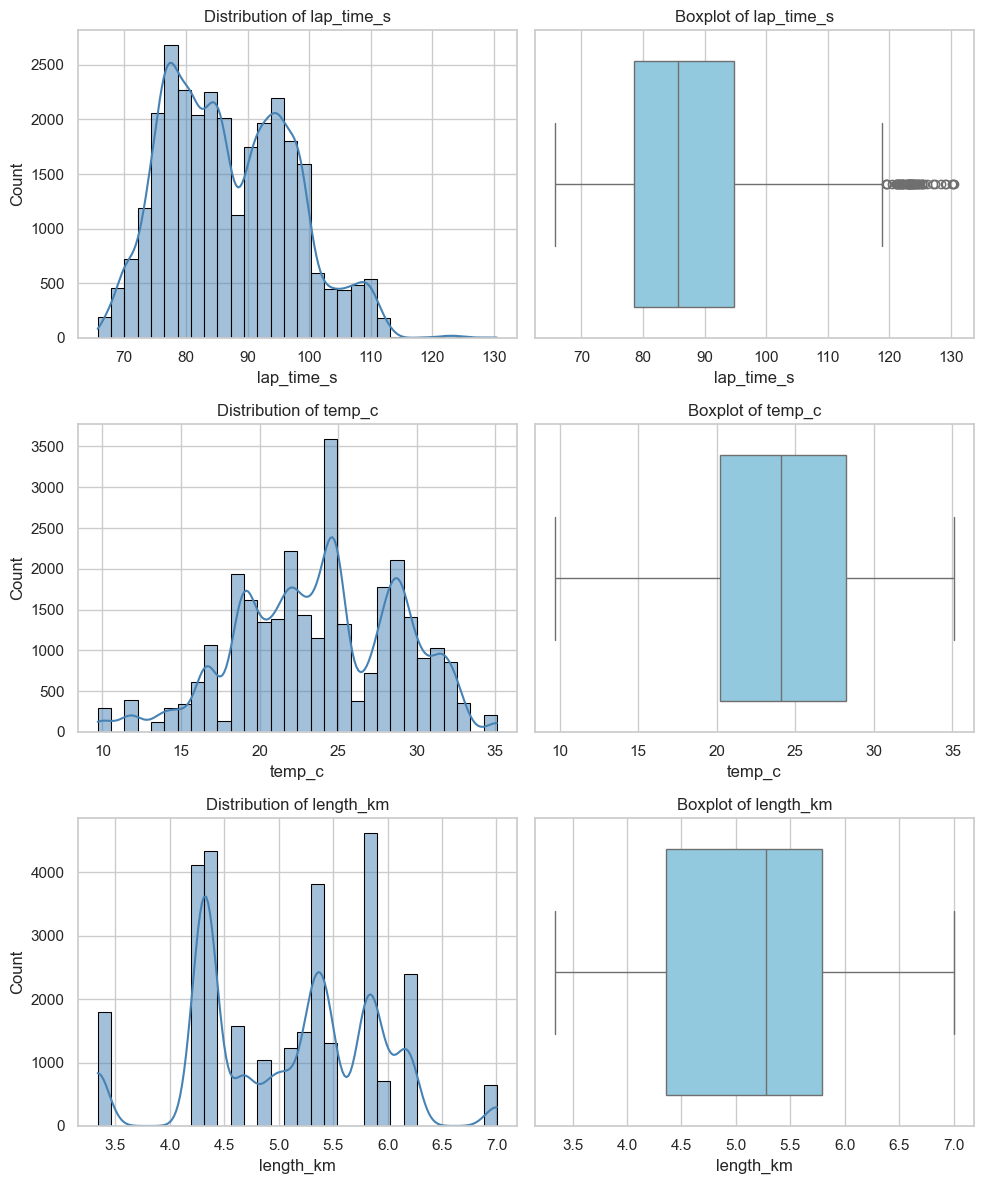

C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\1651019311.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=ax, order=order, palette="crest", hue=None, legend=False)
C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\1651019311.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\1651019311.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=ax, order=order, palette="crest", hue=None, legend=False)
C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\1651

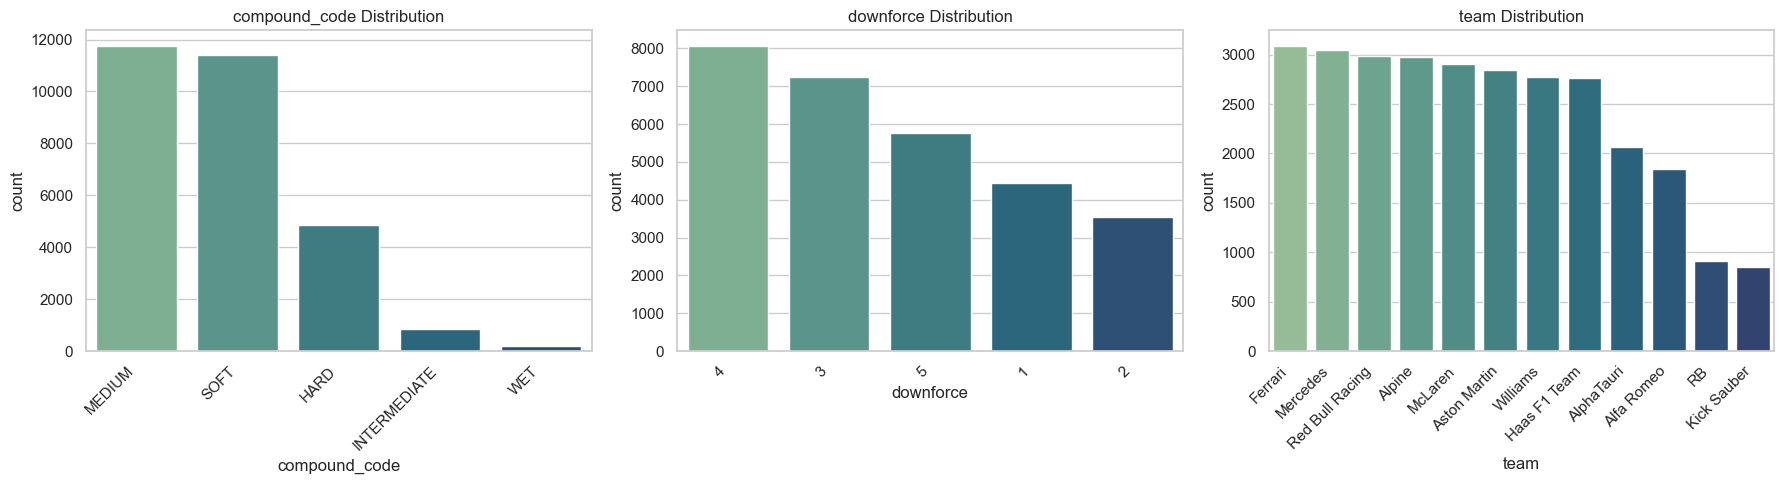

In [65]:
# --- 1.1 Univariate Analysis ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Variables to analyze
num_vars = ["lap_time_s", "temp_c", "length_km"]
cat_vars = ["compound_code", "downforce", "team"]

# --- Numerical variables ---
fig, axes = plt.subplots(len(num_vars), 2, figsize=(10, 4*len(num_vars)))
for i, col in enumerate(num_vars):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i,0], edgecolor="black", color="steelblue")
    axes[i,0].set_title(f"Distribution of {col}")
    sns.boxplot(x=df[col], ax=axes[i,1], color="skyblue")
    axes[i,1].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# --- Categorical / ordinal variables ---
fig, axes = plt.subplots(1, len(cat_vars), figsize=(18, 5))

for i, col in enumerate(cat_vars):
    # Sort by count for better readability (esp. for 'team')
    order = df[col].value_counts().index
    ax = axes[i]
    sns.countplot(x=df[col], ax=ax, order=order, palette="crest", hue=None, legend=False)
    ax.set_title(f"{col} Distribution")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add labels, skipping the first bar
    for j, container in enumerate(ax.containers):
        for k, bar in enumerate(container):
            if k > 0:  # Skip the first bin
                ax.bar_label([int(bar.get_height())], label_type='edge', padding=2, fontsize=9)
    
plt.tight_layout()
plt.show()


In [66]:
# --- 1.2 Summary Statistics ---

# Key numerical variables
num_vars = [
    "lap_time_s", "temp_c", "humidity_pct", "precip_mm",
    "wind_speed_ms", "length_km"
]

# Compute summary statistics
summary_stats = df[num_vars].describe().T  # Transpose for readability

# Add extra metrics: variance and IQR
summary_stats["variance"] = df[num_vars].var()
summary_stats["iqr"] = df[num_vars].quantile(0.75) - df[num_vars].quantile(0.25)

# Reorder columns for clarity
summary_stats = summary_stats[
    ["count", "mean", "std", "variance", "min", "25%", "50%", "75%", "iqr", "max"]
]

display(summary_stats.round(3))


,count,mean,std,variance,min,25%,50%,75%,iqr,max
lap_time_s,29067.0,87.089,10.268,105.426,65.685,78.611,85.724,94.842,16.230,130.475
temp_c,29067.0,23.824,5.065,25.658,9.700,20.200,24.100,28.200,8.000,35.100
humidity_pct,29067.0,54.174,14.934,223.029,17.000,45.000,54.000,64.000,19.000,96.000
precip_mm,29067.0,0.085,0.356,0.127,0.000,0.000,0.000,0.000,0.000,3.400
wind_speed_ms,29067.0,4.097,2.514,6.320,0.389,2.000,3.611,5.556,3.556,11.944
length_km,29067.0,5.065,0.824,0.678,3.337,4.361,5.281,5.793,1.432,7.004


In [67]:
# Section 2
# ----- Bivariate Analysis: setup -----
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def corr_text(x, y, df, method="both"):
    s = []
    df_clean = df[[x, y]].dropna()
    if method in ("pearson", "both"):
        r = df_clean[x].corr(df_clean[y], method="pearson")
        s.append(f"Pearson r={r:.2f}")
    if method in ("spearman", "both"):
        rho = df_clean[x].corr(df_clean[y], method="spearman")
        s.append(f"Spearman ρ={rho:.2f}")
    return " | ".join(s)


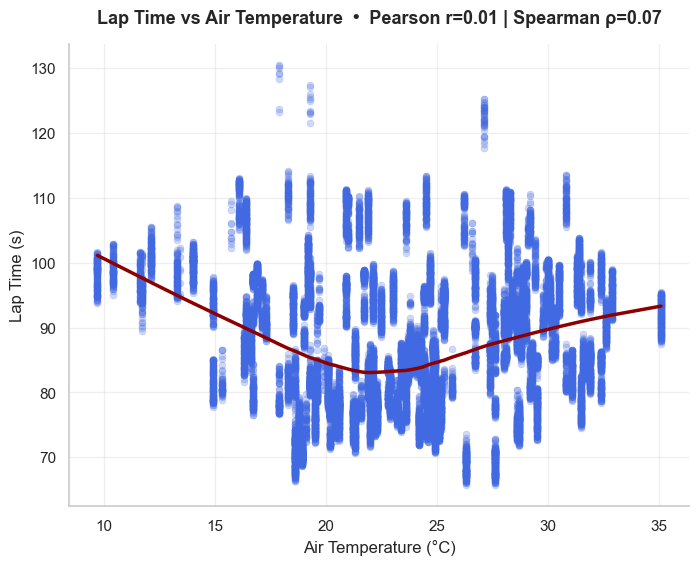

In [68]:
# Lap time vs air temperature
x, y = "temp_c", "lap_time_s"
txt = corr_text(x, y, df, method="both")

plt.figure(figsize=(8,6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=df, x=x, y=y,
    alpha=0.25, s=25,
    edgecolor=None, color="royalblue"
)

# Add a LOWESS (locally weighted) smooth line for non-linear trends
sns.regplot(
    data=df, x=x, y=y,
    scatter=False, lowess=True,
    color="darkred", line_kws={"linewidth": 2.5}
)

# Format labels and title
plt.title(f"Lap Time vs Air Temperature  •  {txt}",
          fontsize=13, fontweight="bold", pad=15)
plt.xlabel("Air Temperature (°C)", fontsize=12)
plt.ylabel("Lap Time (s)", fontsize=12)

sns.despine()
plt.grid(alpha=0.3)

plt.show()


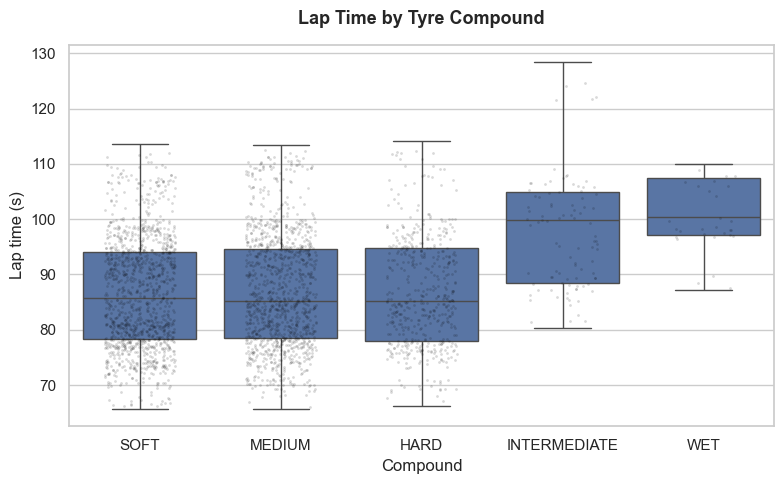

In [69]:
# Lap time vs compound_code (categorical)
plt.figure(figsize=(8,5))
order = ["SOFT","MEDIUM","HARD","INTERMEDIATE","WET"]
ax = sns.boxplot(
    data=df, x="compound_code", y="lap_time_s",
    order=[c for c in order if c in df["compound_code"].unique()],
    showfliers=False,
)
sns.stripplot(
    data=df.sample(min(3000, len(df)), random_state=42),  # subsample for legibility
    x="compound_code", y="lap_time_s",
    order=[c for c in order if c in df["compound_code"].unique()],
    color="black", alpha=0.15, size=2, jitter=0.25
)
ax.set_title("Lap Time by Tyre Compound", fontsize=13, fontweight="bold", pad=15)
ax.set_xlabel("Compound")
ax.set_ylabel("Lap time (s)")
plt.tight_layout()
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\13180713.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


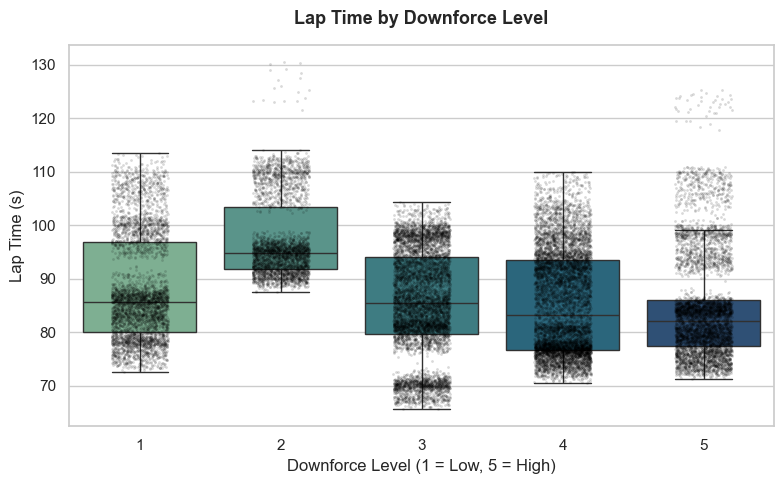

In [70]:
# --- Lap Time vs Downforce ---
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x="downforce",
    y="lap_time_s",
    palette="crest",
    showfliers=False
)
sns.stripplot(
    data=df,
    x="downforce",
    y="lap_time_s",
    color="black",
    alpha=0.15,
    size=2,
    jitter=0.2
)

plt.title("Lap Time by Downforce Level", fontsize=13, fontweight="bold", pad=15)
plt.xlabel("Downforce Level (1 = Low, 5 = High)")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()


In [ ]:
# --- Multivariate Analysis: Multiple Linear Regression ---
import statsmodels.formula.api as smf
import pandas as pd

# Weather + track + setup
features = [
    "temp_c", "humidity_pct", "wind_speed_ms",
    "length_km", "downforce", "traction",
    "asphalt_grip", "asphalt_abrasion", "track_evolution"
]

# Keep numeric only and drop NAs
model_df = df[["lap_time_s"] + features].dropna()

# Fit linear regression model
mlr = smf.ols(
    "lap_time_s ~ temp_c + humidity_pct + wind_speed_ms + length_km + downforce + traction + asphalt_grip + asphalt_abrasion + track_evolution",
    data=model_df
).fit(cov_type="HC3")

# View results summary (coefficients + significance)
print(mlr.summary())


                            OLS Regression Results                            
Dep. Variable:             lap_time_s   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 2.012e+04
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:05:17   Log-Likelihood:                -83728.
No. Observations:               29067   AIC:                         1.675e+05
Df Residuals:                   29057   BIC:                         1.676e+05
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -20.6652      0.437  

PCA:

In [ ]:
# Create a normalized lap-time variable
df["lap_time_ratio"] = df["lap_time_s"] / df["length_km"]

# Interaction terms
df["aero_efficiency"] = df["downforce"] * df["length_km"]
df["surface_quality"] = df["track_evolution"] * df["asphalt_grip"]

# Define numeric features for PCA
features = [
    "lap_time_ratio", "tyre_age_laps",
    "temp_c", "humidity_pct", "wind_speed_ms",
    "downforce", "track_evolution",
    "tyre_stress", "asphalt_grip",
    "aero_efficiency", "surface_quality"
]

# Drop rows with missing values in those columns
X = df[features].dropna()

# Standardize (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [73]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)


df_pca3 = df.loc[X.index].copy()
df_pca3["PCA1"], df_pca3["PCA2"], df_pca3["PCA3"] = X_pca3[:,0], X_pca3[:,1], X_pca3[:,2]

print("Explained variance:", pca3.explained_variance_ratio_,
      "Total:", round(sum(pca3.explained_variance_ratio_)*100, 2), "%")



Explained variance: [0.25214659 0.20563138 0.15538792] Total: 61.32 %


Feature variances:


track_evolution      0.728087
asphalt_grip         0.855034
tyre_stress          1.236134
downforce            1.743831
lap_time_ratio       4.235840
wind_speed_ms        6.319609
surface_quality     12.584321
temp_c              25.657904
tyre_age_laps       29.117270
aero_efficiency     33.130054
humidity_pct       223.028981
dtype: float64

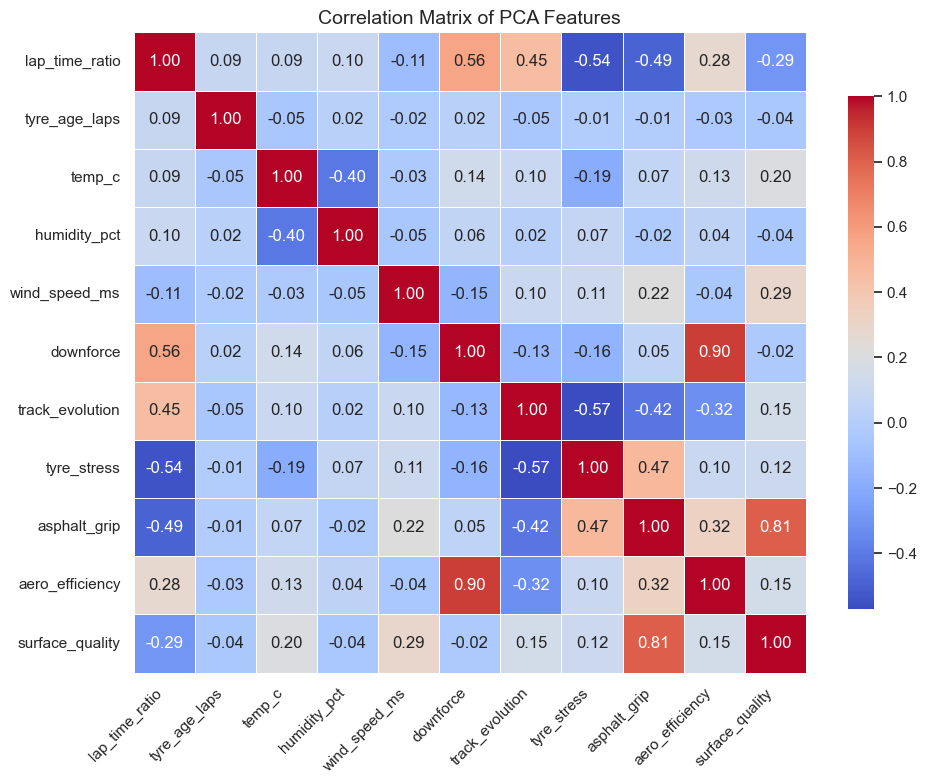

In [ ]:
# Check variance of numeric features
print("Feature variances:")
display(df[features].var().sort_values())

# Correlation matrix
corr = df[features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of PCA Features", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


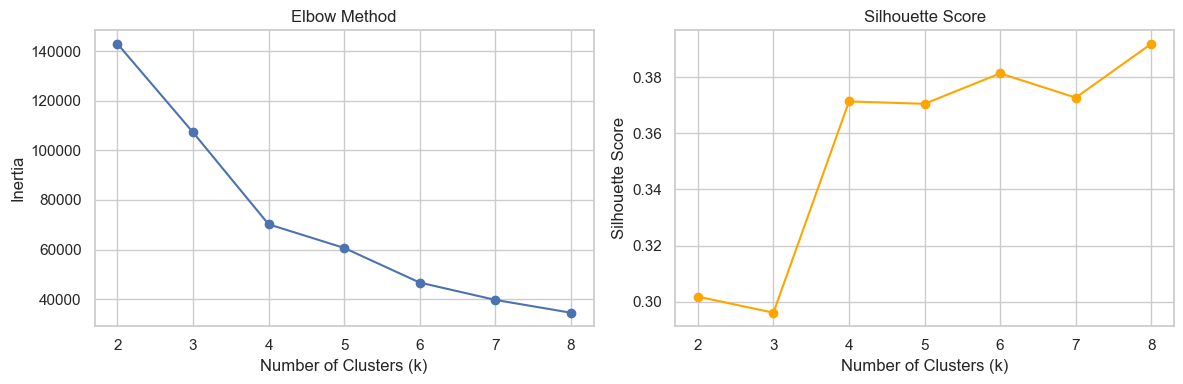

In [ ]:
# Elbow and silhouette to find optimal K
rom sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X_cluster = df_pca3[["PCA1", "PCA2", "PCA3"]]

inertias = []
sil_scores = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_cluster, labels))

# --- Plot elbow and silhouette ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K, inertias, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Inertia")

ax[1].plot(K, sil_scores, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


Cluster counts:
 Cluster
0    3215
1    7518
2    3967
3    3803
4    5050
5    5490
Name: count, dtype: int64


C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\972480426.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("tab10", k_opt),
C:\Users\Justin\AppData\Local\Temp\ipykernel_22580\972480426.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  marker="X", s=200, c=np.arange(k_opt), cmap=plt.cm.get_cmap("tab10", k_opt),


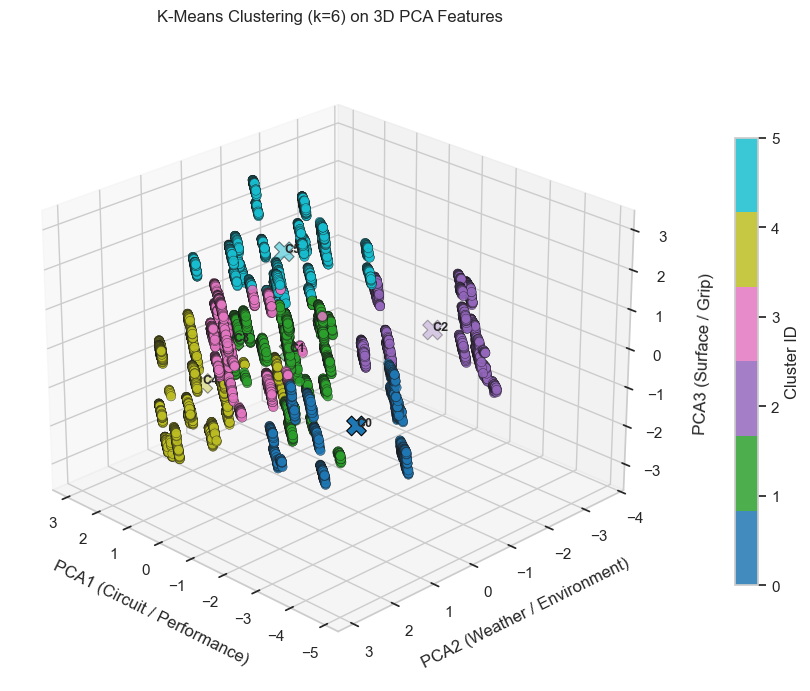

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

k_opt = 6

# Make sure PCA columns are present
required = {"PCA1","PCA2","PCA3"}
missing = required - set(df_pca3.columns)
if missing:
    raise ValueError(f"df_pca3 is missing columns: {missing}. Re-run the PCA-3 cell first.")

# Create Cluster column if it's missing
if "Cluster" not in df_pca3.columns:
    km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
    df_pca3["Cluster"] = km_final.fit_predict(df_pca3[["PCA1","PCA2","PCA3"]])
else:
    # if you already have km_final from before, keep using it;
    # otherwise recompute centroids just for plotting
    km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
    km_final.fit(df_pca3[["PCA1","PCA2","PCA3"]])

print("Cluster counts:\n", df_pca3["Cluster"].value_counts().sort_index())

# 3D Plot
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df_pca3["PCA1"], df_pca3["PCA2"], df_pca3["PCA3"],
    c=df_pca3["Cluster"],
    cmap=plt.cm.get_cmap("tab10", k_opt),
    s=45,
    alpha=0.85,
    edgecolor='k',
    linewidth=0.3
)

# Centroids
centroids = km_final.cluster_centers_
ax.scatter(
    centroids[:,0], centroids[:,1], centroids[:,2],
    marker="X", s=200, c=np.arange(k_opt), cmap=plt.cm.get_cmap("tab10", k_opt),
    edgecolor="black", linewidth=0.8
)
# Label centroids
for i, (x,y,z) in enumerate(centroids):
    ax.text(x, y, z, f"C{i}", fontsize=9, weight="bold")

# Labels / styling
ax.set_xlabel("PCA1 (Circuit / Performance)", labelpad=10)
ax.set_ylabel("PCA2 (Weather / Environment)", labelpad=10)
ax.set_zlabel("PCA3 (Surface / Grip)", labelpad=10)
ax.set_title(f"K-Means Clustering (k={k_opt}) on 3D PCA Features", pad=15)
ax.view_init(elev=25, azim=135)
ax.grid(True, linestyle="--", alpha=0.35)
ax.set_facecolor("white")

cbar = plt.colorbar(sc, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label("Cluster ID")
plt.tight_layout()
plt.show()




In [ ]:
prof_df = df_pca3.copy()

# Cluster sizes and means
cluster_sizes = prof_df.groupby("Cluster").size().rename("n")
cluster_means = prof_df.groupby("Cluster")[summary_cols].mean().round(2)

display(cluster_sizes.to_frame())
display(cluster_means)


,n
Cluster,
0,3215
1,7518
2,3967
3,3803
4,5050
5,5490


,lap_time_ratio,lap_time_s,tyre_age_laps,temp_c,humidity_pct,precip_mm,wind_speed_ms,length_km,downforce,tyre_stress,asphalt_grip,track_evolution,surface_quality
Cluster,,,,,,,,,,,,,
0,21.36,81.10,8.25,23.55,57.54,0.13,2.15,3.83,5.00,1.44,1.26,4.47,5.60
1,16.82,82.07,9.72,22.83,55.51,0.08,4.13,4.89,3.24,3.38,2.63,3.55,9.34
2,16.81,88.55,8.83,20.80,56.01,0.06,3.56,5.33,1.00,3.40,1.50,4.40,6.33
3,18.73,89.22,8.93,28.38,48.67,0.08,3.56,4.77,4.67,2.97,2.84,4.11,11.69
4,16.42,90.36,8.12,21.08,60.85,0.14,3.91,5.53,3.75,5.00,3.44,2.84,9.74
5,16.43,91.96,7.26,26.91,46.76,0.03,6.12,5.62,2.40,3.08,3.32,4.24,13.94


In [ ]:
print("Joined dataset shape:", df.shape)
print("Unique years:", df["year"].unique())
print("Unique sessions:", df["session"].unique())
print("Rows before PCA filtering:", len(df))

# Check how many remain after PCA feature dropna
X = df[features].dropna()
print("Rows after PCA dropna:", len(X))


Joined dataset shape: (29067, 33)
Unique years: [2022 2023 2024]
Unique sessions: ['FP1' 'FP2' 'FP3']
Rows before PCA filtering: 29067
Rows after PCA dropna: 29054
